<a href="https://colab.research.google.com/github/varsha116/Smart-Surveillance-System/blob/main/GitHubCrowdManagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

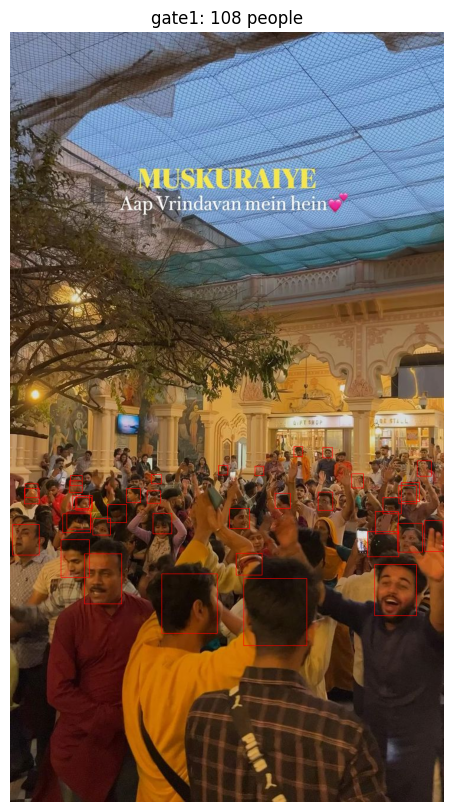


image 1/1 /content/drive/MyDrive/mirasys/Gates_crowd/Gate2.jpg: 640x384 64 peoples, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


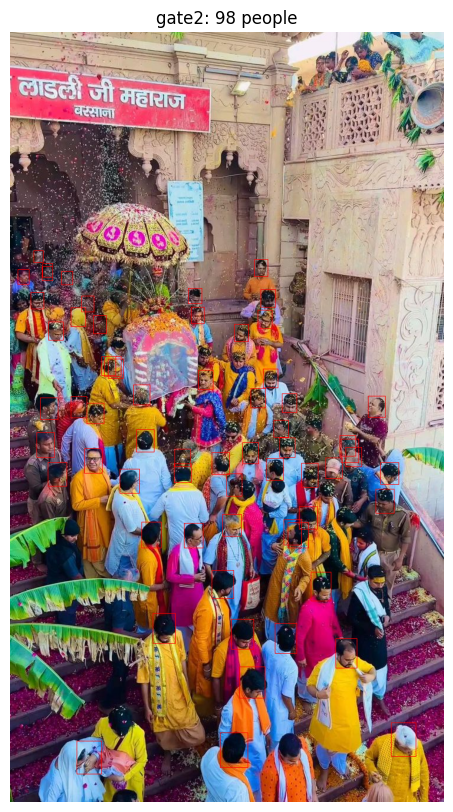


image 1/1 /content/drive/MyDrive/mirasys/Gates_crowd/Gate3.jpg: 640x384 57 peoples, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


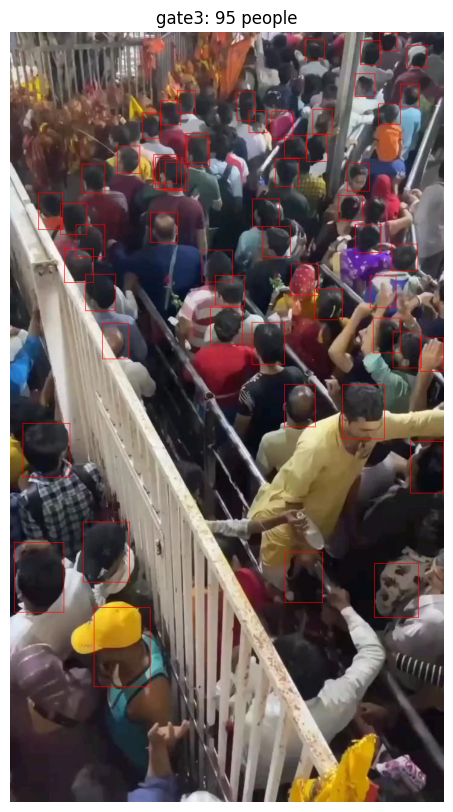


image 1/1 /content/drive/MyDrive/mirasys/Gates_crowd/Gate4.jpg: 640x384 25 peoples, 9.4ms
Speed: 3.2ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


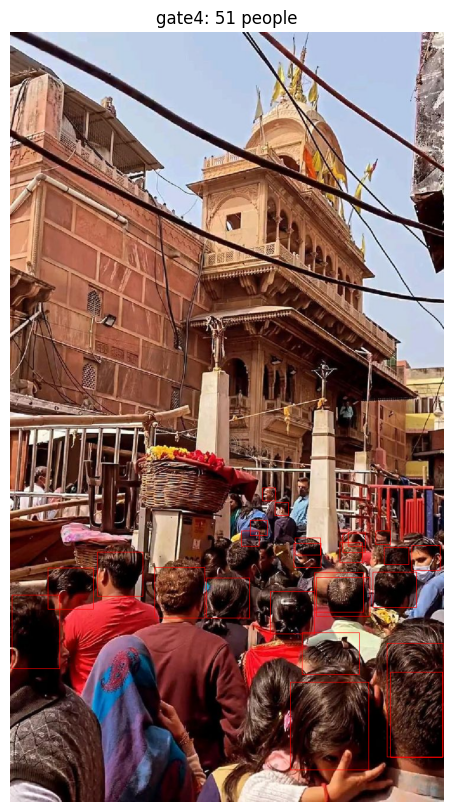

In [ ]:
# Install dependencies (YOLOv5/YOLOv8)
!pip install ultralytics opencv-python
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# Initialize the YOLO model
model = YOLO("/content/drive/MyDrive/mirasys/TrainedModelCrowdDetection/best_model/detect/train/weights/best.pt")

# Define the paths to images for different gates
gate_images = {
    "gate1": "/content/drive/MyDrive/mirasys/Gates_crowd/Gate1.jpg",
    "gate2": "/content/drive/MyDrive/mirasys/Gates_crowd/Gate2.jpg",
    "gate3": "/content/drive/MyDrive/mirasys/Gates_crowd/Gate3.jpg",
    "gate4": "/content/drive/MyDrive/mirasys/Gates_crowd/Gate4.jpg",
}

# Define the base threshold for crowd density
base_threshold = 100

# Function to process images and calculate crowd densities
def process_gates(gate_images, model, dynamic_scaling_factor=1.2):
    gate_counts = {}
    for gate, image_path in gate_images.items():
        # Perform inference
        results = model.predict(source=image_path, conf=0.15)

        # Count the number of detected persons
        person_count = sum(len(result.boxes.xyxy) for result in results)
        gate_counts[gate] = person_count

    # Adjust threshold dynamically based on total crowd
    total_crowd = sum(gate_counts.values())
    dynamic_threshold = base_threshold * dynamic_scaling_factor if total_crowd > 4 * base_threshold else base_threshold

    return gate_counts, dynamic_threshold

# Function to generate recommendations
def generate_recommendations(gate_counts, threshold):
    recommendations = {}
    excess_crowd = {}
    available_capacity = {}

    # Calculate excess and available capacities
    for gate, count in gate_counts.items():
        if count > threshold:
            excess_crowd[gate] = count - threshold
        else:
            available_capacity[gate] = threshold - count

    # Redistribute excess crowd
    for overcrowded_gate, excess in excess_crowd.items():
        redistribution_plan = {}
        for gate, capacity in available_capacity.items():
            if excess > 0 and capacity > 0:
                to_move = min(excess, capacity)
                redistribution_plan[gate] = to_move
                available_capacity[gate] -= to_move
                excess -= to_move

        # If any excess remains, suggest stopping it
        if excess > 0:
            redistribution_plan["stop"] = excess

        recommendations[overcrowded_gate] = redistribution_plan

    return recommendations

# Process gates and get crowd data
gate_counts, dynamic_threshold = process_gates(gate_images, model)

# Generate recommendations based on crowd data
recommendations = generate_recommendations(gate_counts, dynamic_threshold)

# Display results
print("\n--- Gate-wise Crowd Counts ---")
for gate, count in gate_counts.items():
    print(f"{gate}: {count} people")

print(f"\nDynamic Threshold: {dynamic_threshold} people")

print("\n--- Recommendations for Authorities ---")
for gate, redistribution in recommendations.items():
    print(f"\nGate: {gate}")
    for target_gate, count in redistribution.items():
        if target_gate == "stop":
            print(f"  - Stop {count} people at this gate.")
        else:
            print(f"  - Redirect {count} people to {target_gate}.")

# Example visualization for a specific gate
for gate, image_path in gate_images.items():
    # Load image
    image = cv2.imread(image_path)

    # Perform inference
    results = model.predict(source=image_path, conf=0.25)

    # Draw bounding boxes
    def draw_boxes(image, results):
        for result in results:
            for box in result.boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 1)
        return image

    # Prepare for visualization
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output_image = draw_boxes(image_rgb, results)

    # Display image
    plt.figure(figsize=(10, 10))
    plt.imshow(output_image)
    plt.title(f"{gate}: {gate_counts[gate]} people")
    plt.axis("off")
    plt.show()

    # Optionally save the output
    output_image_bgr = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"/content/drive/MyDrive/mirasys/output_{gate}.jpg", output_image_bgr)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import numpy as np

# Assuming you have ground truth labels and model predictions
# Replace these with actual values from your dataset
true_labels = []  # List of actual labels (0 for no person, 1 for person)
predicted_labels = []  # List of predicted labels (0 or 1)
predicted_probs = []  # List of predicted probabilities for the positive class (if available)

# Process each gate to collect true and predicted values
for gate, image_path in gate_images.items():
    results = model.predict(source=image_path, conf=0.15)

    # Count detected persons
    person_count = sum(len(result.boxes.xyxy) for result in results)

    # Define actual label (based on ground truth data you have)
    actual_count = 100  # Replace this with actual person count for this image
    true_labels.append(1 if actual_count > 0 else 0)
    predicted_labels.append(1 if person_count > 0 else 0)

    # If you have confidence scores from YOLO, extract them
    if results and hasattr(results[0], 'probs'):
        predicted_probs.append(results[0].probs)  # Adjust based on YOLO output
    else:
        predicted_probs.append(1.0 if person_count > 0 else 0.0)  # Default probability

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
predicted_probs = np.array(predicted_probs)

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, zero_division=1)
recall = recall_score(true_labels, predicted_labels, zero_division=1)
f1 = f1_score(true_labels, predicted_labels, zero_division=1)

# Calculate AUC-ROC (only if probability scores are available)
auc_roc = roc_auc_score(true_labels, predicted_probs) if len(set(true_labels)) > 1 else "N/A"

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc}")



image 1/1 /content/drive/MyDrive/mirasys/Gates_crowd/Gate1.jpg: 640x384 108 peoples, 12.4ms
Speed: 3.8ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/drive/MyDrive/mirasys/Gates_crowd/Gate2.jpg: 640x384 98 peoples, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/drive/MyDrive/mirasys/Gates_crowd/Gate3.jpg: 640x384 95 peoples, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/drive/MyDrive/mirasys/Gates_crowd/Gate4.jpg: 640x384 51 peoples, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
AUC-ROC: N/A
